# Feature Expansion - Polynomials

## 1) Warmup

Which types of feature engineering or techniques/tools for feature engineering have you seen last week?

- binning
- imputation - filling missing values
- pipeline
- OneHotEncoder
- scaling
- ColumnTransformer
- log transformation

Two new techniques for today:
- Polynomial Features
- Interaction Terms

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Set figure size to (12, 6)
plt.rcParams['figure.figsize'] = (12,6)

## 2.1) Polynomials

"A polynomial is a mathematical expression consisting of variables, coefficients, and the operations of addition, subtraction, multiplication, and non-negative integer exponents." - https://brilliant.org/wiki/polynomials/



or

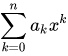

In [27]:
# Load the Anscombe dataset
df = sns.load_dataset("anscombe")
df.head()

,dataset,x,y
0,I,10.0,8.04
1,I,8.0,6.95
2,I,13.0,7.58
3,I,9.0,8.81
4,I,11.0,8.33


In [28]:
df.tail()

,dataset,x,y
39,IV,8.0,5.25
40,IV,19.0,12.50
41,IV,8.0,5.56
42,IV,8.0,7.91
43,IV,8.0,6.89


In [29]:
df.columns

Index(['dataset', 'x', 'y'], dtype='object')

In [30]:
df.dataset.unique()

array(['I', 'II', 'III', 'IV'], dtype=object)

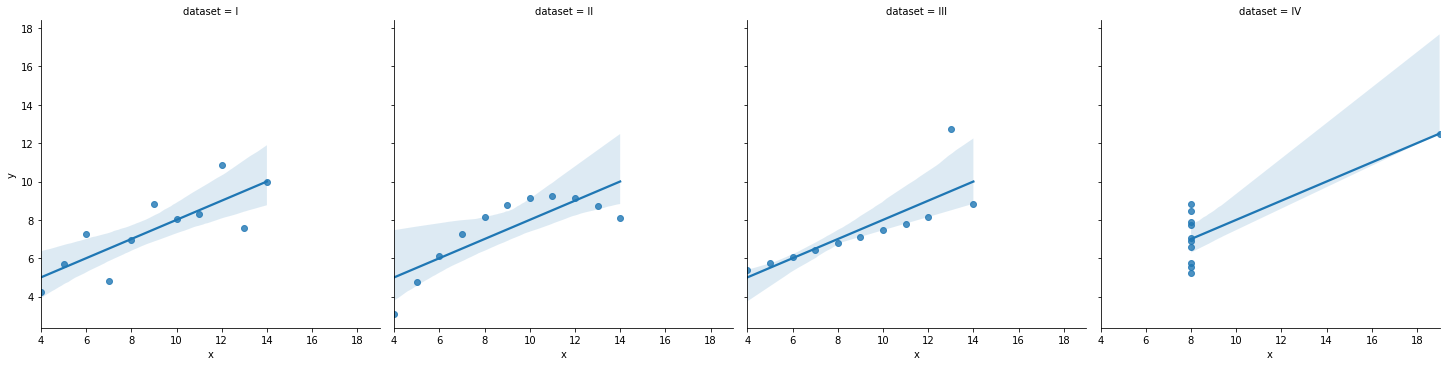

In [31]:
sns.lmplot(x='x', y='y', data=df, col='dataset')

In [32]:
# Filter the DataFrame to only contain dataset II
df = df[df['dataset'] == 'II']

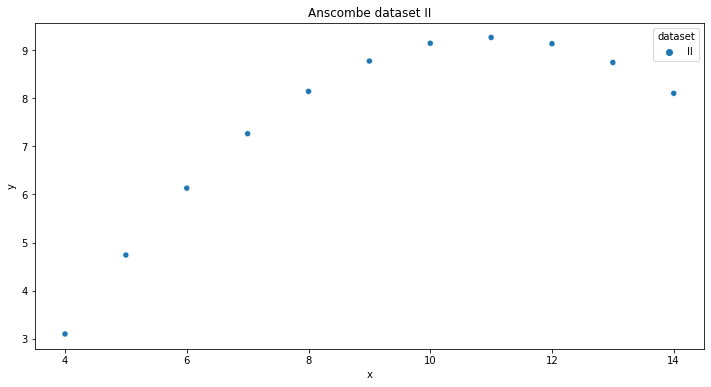

In [33]:
# Visualize the second dataset
sns.scatterplot(x='x', y='y', data=df, hue='dataset')
plt.title('Anscombe dataset II')
plt.show()

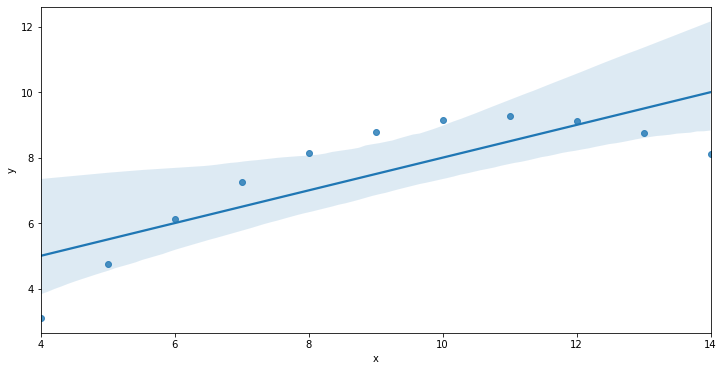

In [34]:
# Create a regplot
sns.regplot(x='x', y='y', data=df)

In [35]:
# Create X and y

X = df[['x']]
y = df['y']

In [36]:
# Create a polynomial model of degree 2

X['x2'] = X['x']**2
X.head()

<ipython-input-36-05aeeb7b25d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['x2'] = X['x']**2


,x,x2
11,10.0,100.0
12,8.0,64.0
13,13.0,169.0
14,9.0,81.0
15,11.0,121.0


We want to fit the regression

$$
\hat{y} = a_0 + a_1 * x + a_2 * x^2
$$

The Linear Regression model will return $a_0$, $a_1$ and $a_2$

In [37]:
# Inspect X


In [38]:
# Run a LinearRegression of X onto y
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [39]:
# Inspect the score
m.score(X, y)

0.999999457857722

In [40]:
# Predict y
y_pred = m.predict(X)

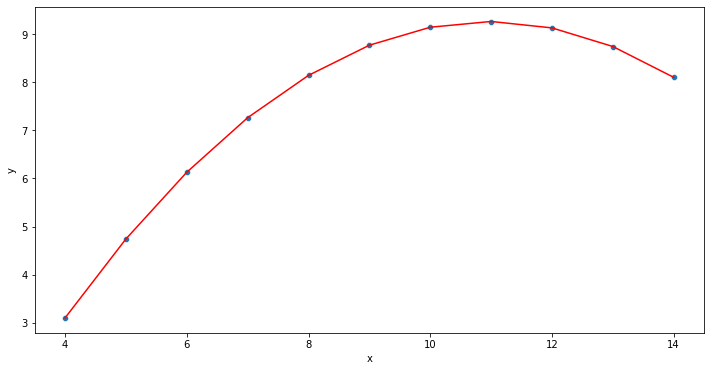

In [41]:
# Visualize the result

sns.scatterplot(x='x', y='y', data=df)
sns.lineplot(x=df['x'], y=y_pred, color='r')

In [42]:
m.coef_ # a_1, a_2

array([ 2.78083916, -0.12671329])

In [43]:
m.intercept_ # a_0

-5.995734265734267

According to our linear regression, the true relationship between x and y would be

$$
\hat{y} = -6 + 2.78 * x - 0.13 * x^2
$$

In [44]:
# Value for x=10
-6 + 2.78 * 10 - 0.13 * 100

8.799999999999997

### 2.2) Polynomials with ColumnTransformers

The ColumnTransformer in general is kind of a tool that allows us to apply transformations to our dataset in a reproducible way.

Reproducible means, that once we defined which feature engineering techniques to apply, we can reuse it to apply the same transformations on the test data.

Steps:
1. Define the ColumnTransformer and the transformations to apply to the data
2. Fit the ColumnTransformer on the training data
3. Transform the training data using the ColumnTransforme
... model training, cross-validation, ..., once we are happy with a model
4. Transform our test data using the same ColumnTransformer (one line of code)

What are the transformations that we can apply to the data:
- One-hot-encode (OneHotEncoder)
- Create polynomial features (PolynomialFeatures)
- Create interaction terms (PolynomialFeatures)
- Binning (KBinsDiscretizer)
- Imputation (SimpleImputer)
- Scale (e.g. StandardScaler)

The ColumnTransformer has limitations, especially you are limited by the choice of provided transformations. However, you can define custom transformations on your data and use them in the ColumnTransformer:
- FunctionTransformer - allows us to write our own custom function and include in a ColumnTransformer

Another slight weekness of the ColumnTransformer is that sequential steps (like first imputing a column and then transforming the imputed result) cannot be performed by the ColumnTransformer directly --> Pipeline

In [1]:
# How to include polynomial features in our ColumnTransformer

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

In [46]:
def impute_group_means(df):
    '''
    Function that imputes column x with the mean of ... group
    '''
    return df['x'].fillna(df.groupby('y').transform('mean'))

In [60]:
# Build a ColumnTransformer

preprocess = ColumnTransformer(
    # list of tuples, where each tuple is a transformation
    # [(name, transformer, columns),
    # (name, transformer, columns)
    # ]
    [
    ('polynomial_features', PolynomialFeatures(degree=2, include_bias=False), ['x']),
    # ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['x']),
    # ('group_imputer', FunctionTransformer(impute_group_means), ['x'])
])

In [61]:
preprocess

ColumnTransformer(transformers=[('polynomial_features',
                                 PolynomialFeatures(include_bias=False),
                                 ['x'])])

The order of the steps in the ColumnTransformer makes a difference only for the order of the columns that we get as a result of the ColumnTransformer.transform()

In [62]:
X = df[['x']]
y = df['y']

In [63]:
type(preprocess)

sklearn.compose._column_transformer.ColumnTransformer

In [64]:
# Fit and transform the data
preprocess.fit(X)
preprocess.transform(X)

array([[ 10., 100.],
       [  8.,  64.],
       [ 13., 169.],
       [  9.,  81.],
       [ 11., 121.],
       [ 14., 196.],
       [  6.,  36.],
       [  4.,  16.],
       [ 12., 144.],
       [  7.,  49.],
       [  5.,  25.]])

In [65]:
# Does the ColumnTransformer produce column names
pd.DataFrame(preprocess.transform(X), columns=preprocess.get_feature_names())

,polynomial_features__x0,polynomial_features__x0^2
0,10.0,100.0
1,8.0,64.0
2,13.0,169.0
3,9.0,81.0
4,11.0,121.0
5,14.0,196.0
6,6.0,36.0
7,4.0,16.0
8,12.0,144.0
9,7.0,49.0


In [66]:
# Equivalent to first fitting and then transformin
preprocess.fit_transform(X)

array([[ 10., 100.],
       [  8.,  64.],
       [ 13., 169.],
       [  9.,  81.],
       [ 11., 121.],
       [ 14., 196.],
       [  6.,  36.],
       [  4.,  16.],
       [ 12., 144.],
       [  7.,  49.],
       [  5.,  25.]])

In [67]:
X_test = df[['x']]

In [68]:
X_test

,x
11,10.0
12,8.0
13,13.0
14,9.0
15,11.0
16,14.0
17,6.0
18,4.0
19,12.0
20,7.0


In [69]:
preprocess.transform(X_test)

array([[ 10., 100.],
       [  8.,  64.],
       [ 13., 169.],
       [  9.,  81.],
       [ 11., 121.],
       [ 14., 196.],
       [  6.,  36.],
       [  4.,  16.],
       [ 12., 144.],
       [  7.,  49.],
       [  5.,  25.]])

### 2.3) Higher Degree Polynomials

In [70]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [71]:
# Set a random seed for reproducibility
np.random.seed(0)

# Choose a number of observations
n_samples = 30 # size of 

# Define the true relationship between X and y
def create_relationship(X):
    '''
    True relationship between X and y.
    
    Parameters
    ----------
    X : ndarray
        Numerical feature values 
        
    Returns
    -------
    y : array-like
    '''
    y = np.cos(1.5 * np.pi * X)
    return y

In [72]:
# Create an array of random x values; x is 1-dimensional
X = np.sort(np.random.rand(n_samples))

# Create an array of y-observations including some randomness
y_true = create_relationship(X) + np.random.randn(n_samples) * 0.1

# Create the hypothetical y-observations without randomness
y_hypothetical = create_relationship(X)

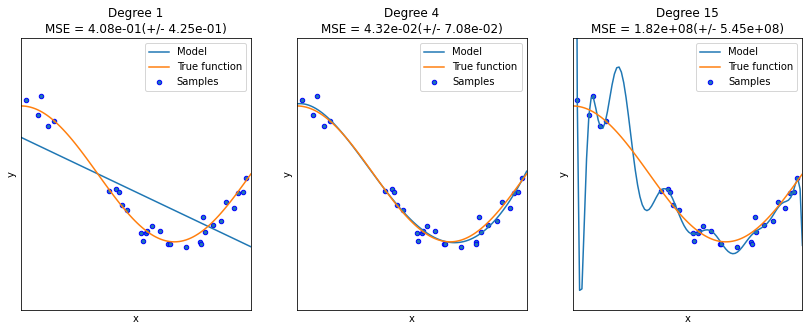

In [73]:
# Choose the degrees of polynomials to include in our analysis
degrees = [1, 4, 15]

# Create a plot and plot the true values and results for all degrees of polynomials
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=True)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y_true)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y_true,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, create_relationship(X_test), label="True function")
    plt.scatter(X, y_true, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()